# Abdul Wahab
# Advanced Data Mining

# Prof. Dr Sohail Asghar


## Fake News Detection: A hybrid CNN-RNN based deep learning approach

# DESCRIPTION OF DATASET
**This dataset consists of about 40000 articles consisting of fake as well as real news. The aim is train the model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.**

# LOADING THE NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# IMPORTING THE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
true = pd.read_csv("/content/drive/MyDrive/implementation/True.csv")

false = pd.read_csv("/content/drive/MyDrive/implementation/Fake.csv")

# DATA VISUALIZATION AND PREPROCESSING

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true['category'] = 1
false['category'] = 0

In [ ]:
df = pd.concat([true,false]) #Merging the 2 datasets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


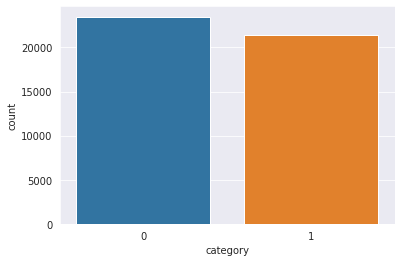

In [ ]:
sns.set_style("darkgrid")
sns.countplot(df.category)

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [ ]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
df.title.count()

44898

In [ ]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

**MERGING ALL THE TEXT DATA INTO 1 COLUMN i.e. 'text'**

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

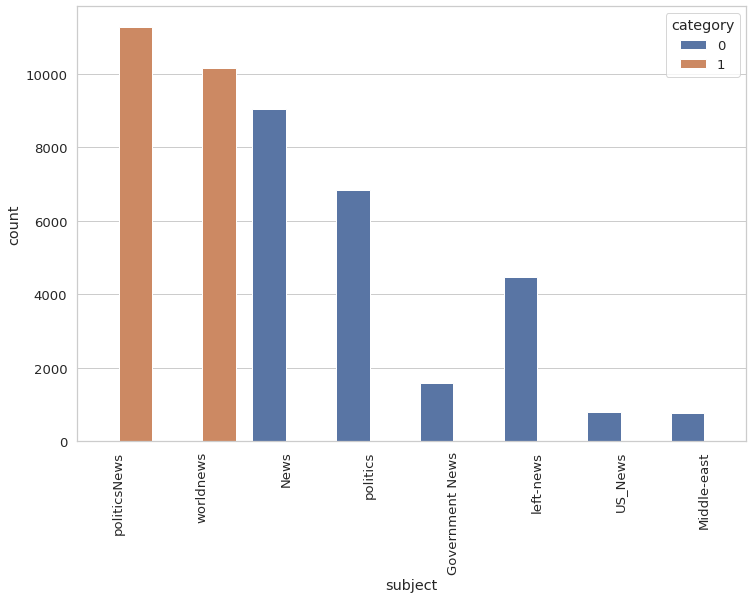

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**SINCE THE TOPICS IN SUBJECT COLUMN ARE DIFFERENT FOR BOTH CATEGORIES, HENCE WE HAVE TO EXCLUDE IT FROM FINAL TEXT COLUMN**

In [ ]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [ ]:
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
STOPWORDS = set(stopwords.words('english'))
punctuation = list(string.punctuation)
STOPWORDS.update(punctuation)

**DATA CLEANING**

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in STOPWORDS:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

**WORDCLOUD FOR REAL TEXT (LABEL - 1)**

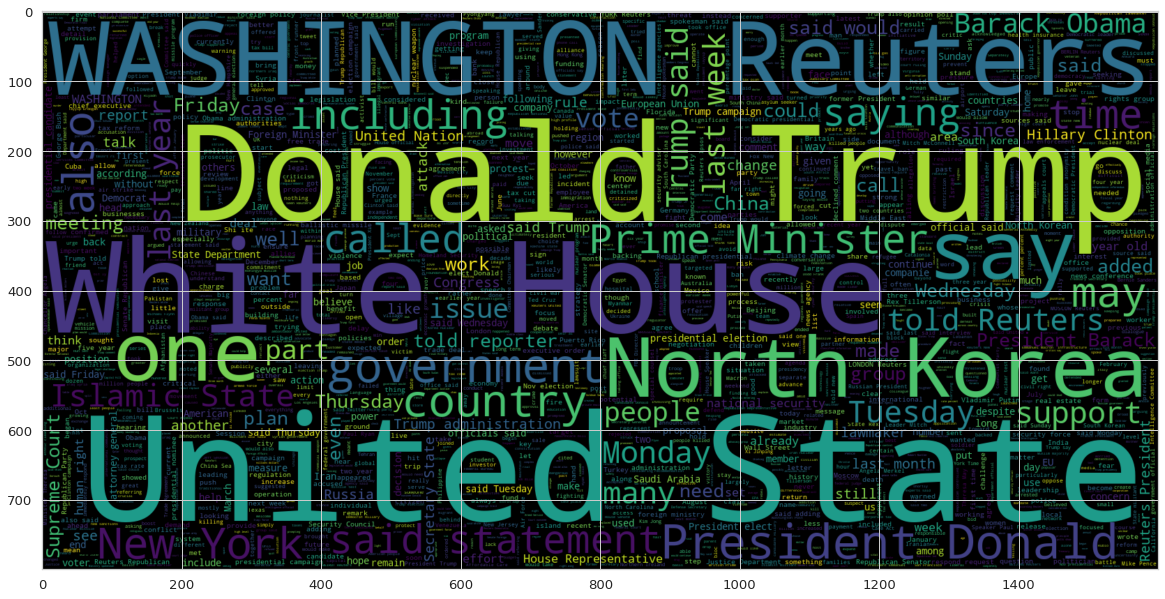

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR FAKE TEXT (LABEL - 0)**

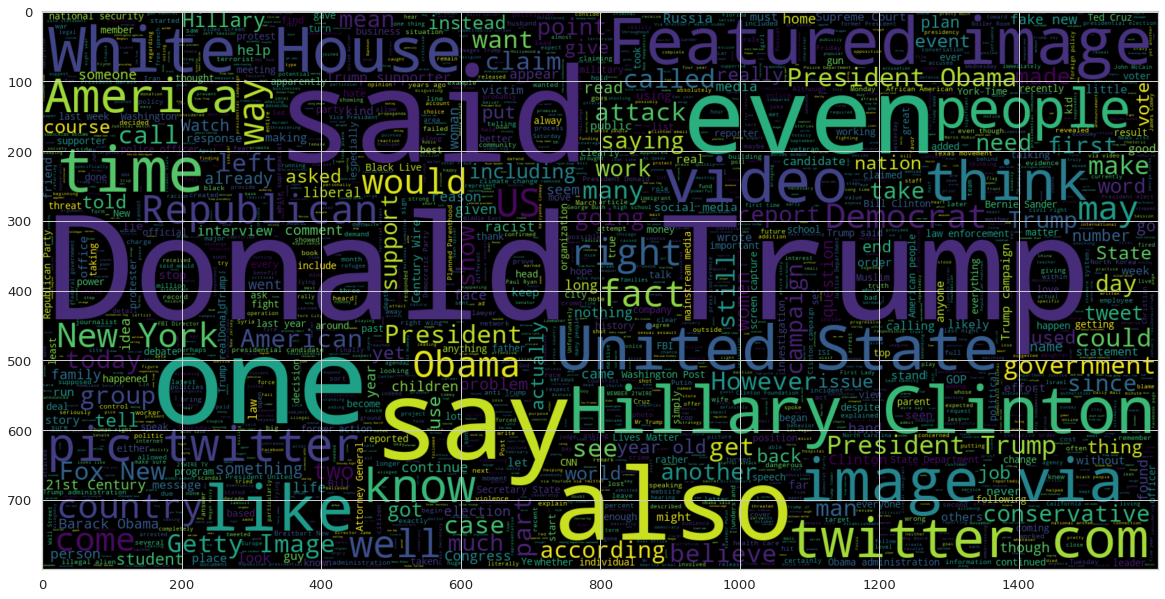

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Donald': 27795,
 'President': 33180,
 'Trump': 111503,
 'U.S.': 50441,
 'also': 30325,
 'one': 29370,
 'people': 33115,
 'said': 93162,
 'said.': 26194,
 'would': 54613}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

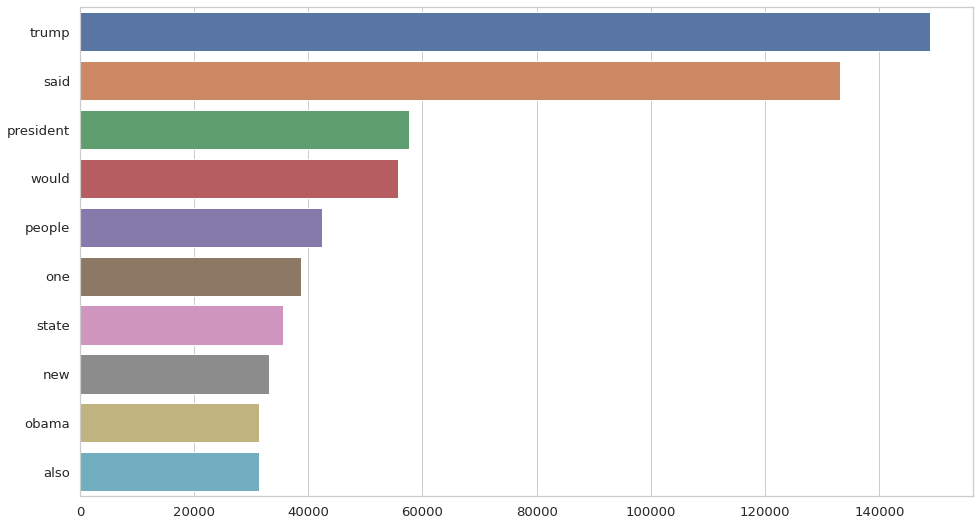

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Bigram Analysis**

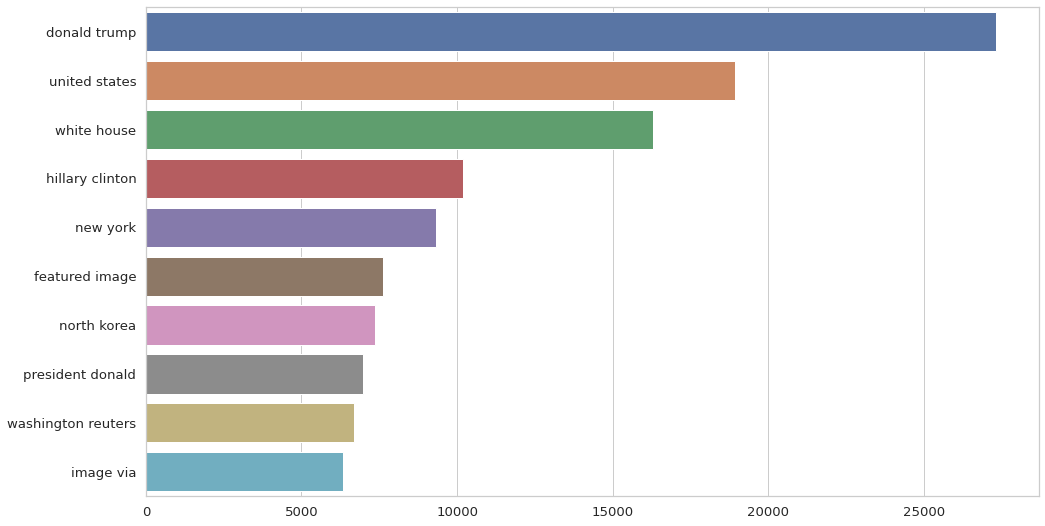

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

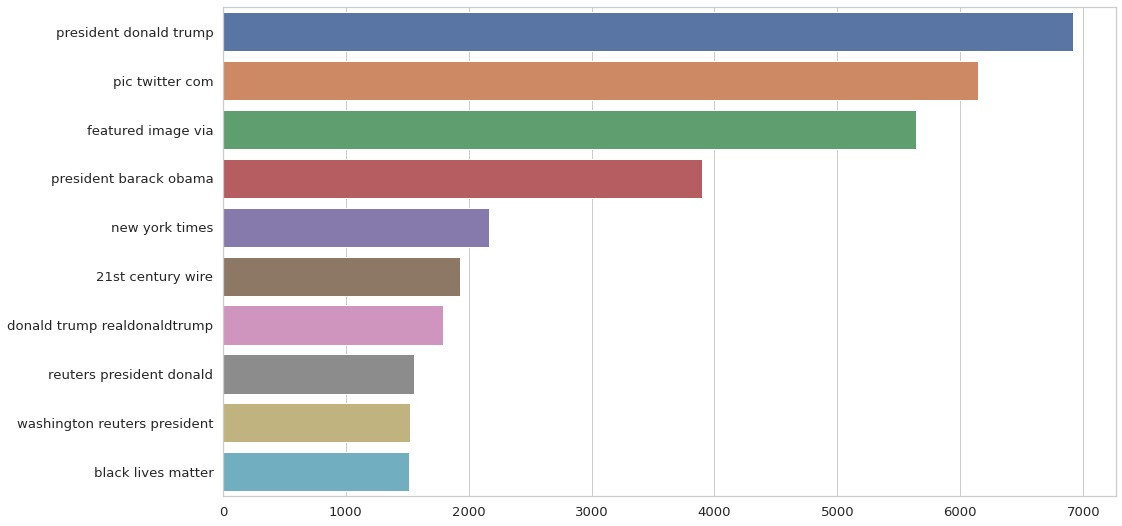

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

**Splitting the data into 2 parts - training and testing data**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [ ]:
max_features = 10000
maxlen = 300

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones**

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
EMBEDDING_FILE = open('/content/drive/MyDrive/implementation/glove.twitter.27B.100d.txt', encoding="utf8")

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in EMBEDDING_FILE)

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


**Some Model Parameters**

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.01)

# TRAINING THE MODEL

# CNN MODEL

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#CNN MODEL 
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 298, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 149, 32)          0         
 )                                                               
                                                                 
 dense (Dense)               (None, 149, 1)            33        
                                                                 
Total params: 1,009,665
Trainable params: 9,665
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 5s 11ms/step - loss: 0.6113 - accuracy: 0.6368 - val_loss: 0.5831 - val_accuracy: 0.6474 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 1s 8ms/step - loss: 0.5736 - accuracy: 0.6634 - val_loss: 0.5719 - val_accuracy: 0.6523 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 1s 8ms/step - loss: 0.5673 - accuracy: 0.6660 - val_loss: 0.5674 - val_accuracy: 0.6727 - lr: 0.0100
Epoch 4/10
132/132 [==============================] - 1s 8ms/step - loss: 0.5641 - accuracy: 0.6707 - val_loss: 0.5659 - val_accuracy: 0.6735 - lr: 0.0100
Epoch 5/10
132/132 [==============================] - 1s 8ms/step - loss: 0.5599 - accuracy: 0.6734 - val_loss: 0.5607 - val_accuracy: 0.6775 - lr: 0.0100
Epoch 6/10
132/132 [==============================] - 1s 9ms/step - loss: 0.5600 - accuracy: 0.6751 - val_loss: 0.5618 - val_accuracy: 0.6771 - lr: 0.0100
Epoch 7/10
132/132 [==============================] - 1s 9ms/step - l

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 3s 3ms/step - loss: 0.5549 - accuracy: 0.6780
Accuracy of the model on Training Data is -  67.8010880947113 %
351/351 [==============================] - 1s 3ms/step - loss: 0.5608 - accuracy: 0.6775
Accuracy of the model on Testing Data is -  67.74736642837524 %


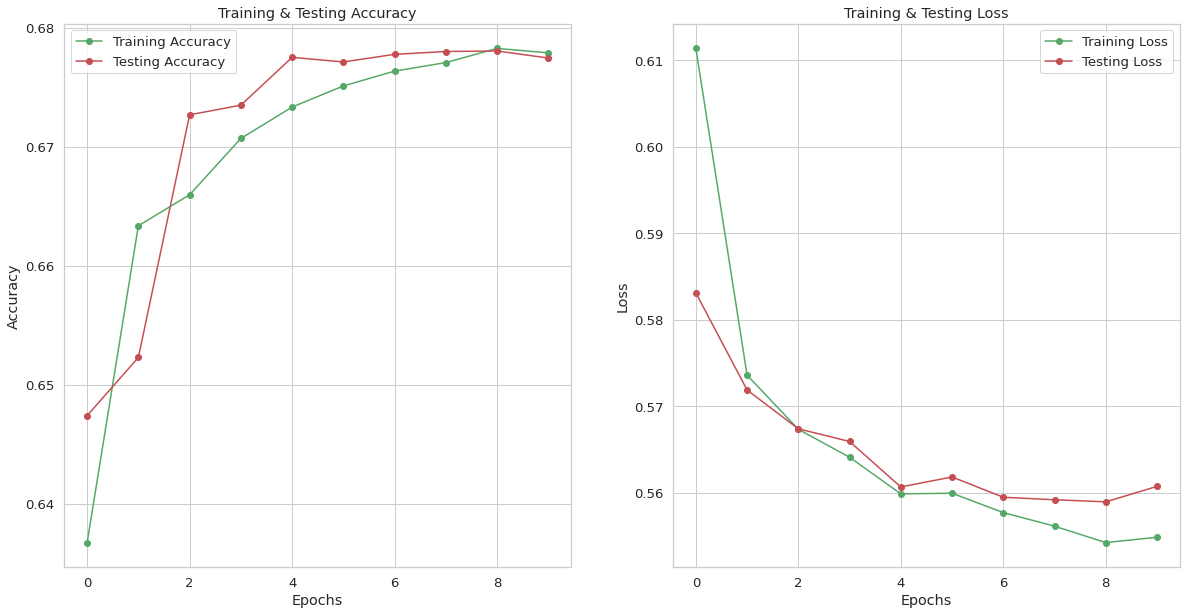

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# LSTM MODEL

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM MODEL
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 10 , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 335s 3s/step - loss: 0.1330 - accuracy: 0.9427 - val_loss: 0.0307 - val_accuracy: 0.9891 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 334s 3s/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0292 - val_accuracy: 0.9903 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 358s 3s/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.0210 - val_accuracy: 0.9933 - lr: 0.0100
Epoch 4/10
132/132 [==============================] - 338s 3s/step - loss: 0.0076 - accuracy: 0.9974 - val_loss: 0.0079 - val_accuracy: 0.9977 - lr: 0.0100
Epoch 5/10
132/132 [==============================] - 338s 3s/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0255 - val_accuracy: 0.9913 - lr: 0.0100
Epoch 6/10
132/132 [==============================] - 334s 3s/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.0135 - val_accuracy: 0.9967 - lr: 0.0100
Epoch 7/10
132/132 [==============================] - 335s 3s/st

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 165s 157ms/step - loss: 0.0026 - accuracy: 0.9992
Accuracy of the model on Training Data is -  99.91684556007385 %
351/351 [==============================] - 55s 155ms/step - loss: 0.0100 - accuracy: 0.9968
Accuracy of the model on Testing Data is -  99.67928528785706 %


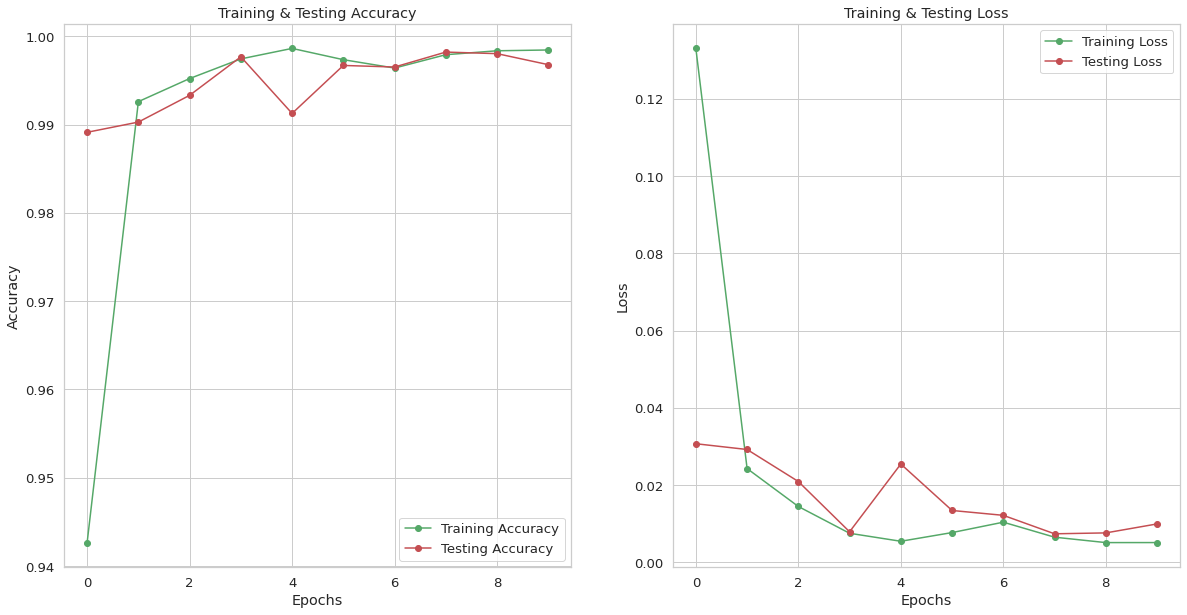

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Hybrid CNN-RNN MODEL

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#HYBRID CNN LSTM MODEL 
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',input_shape=(10000,300)))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(48))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          64128     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 48)                33984     
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,098,161
Trainable params: 98,161
Non-trainable params: 1,000,000
_______________________________________

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 10 , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 7s 31ms/step - loss: 0.1211 - accuracy: 0.9479 - val_loss: 0.0226 - val_accuracy: 0.9933 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 4s 31ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0092 - val_accuracy: 0.9972 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 3s 26ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0071 - val_accuracy: 0.9980 - lr: 0.0100
Epoch 4/10
132/132 [==============================] - 3s 26ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0122 - val_accuracy: 0.9960 - lr: 0.0100
Epoch 5/10
132/132 [==============================] - 3s 26ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0082 - val_accuracy: 0.9978 - lr: 0.0100
Epoch 6/10
132/132 [==============================] - 3s 26ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0081 - val_accuracy: 0.9979 - lr: 0.0100
Epoch 7/10
132/132 [==============================] - 3s 26ms/st

# ANALYSIS AFTER TRAINING OF MODEL

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 7s 7ms/step - loss: 0.0021 - accuracy: 0.9993
Accuracy of the model on Training Data is -  99.92575645446777 %
351/351 [==============================] - 2s 5ms/step - loss: 0.0103 - accuracy: 0.9971
Accuracy of the model on Testing Data is -  99.70601201057434 %


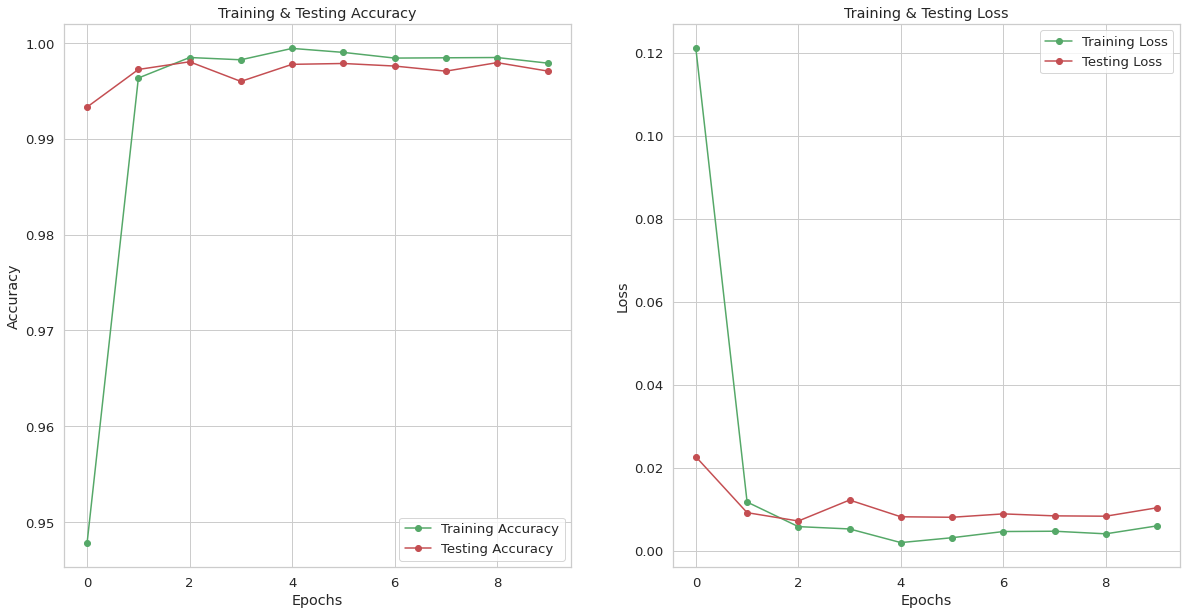

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

**Evaluation Metrics**

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



**Confusion Matrix**

In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[5850,    8],
       [  25, 5342]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(63.5, 0.5, 'Actual')

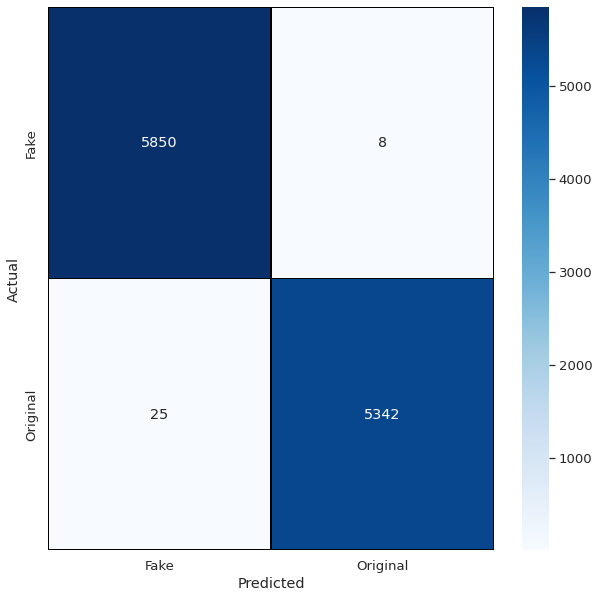

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

**Naive Bayes model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(x_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'
     .format((NB.score(x_train, y_train)*100)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format((NB.score(X_test, y_test)*100)))


Accuracy of NB  classifier on training set: 59.61
Accuracy of NB classifier on test set: 60.19


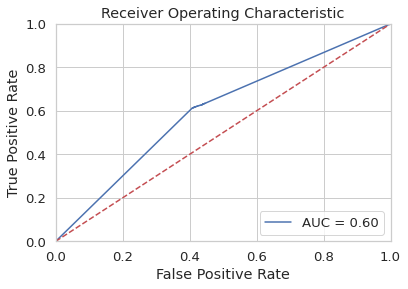

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = NB.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(x_train, y_train)
print('Accuracy of Logistic Regression on training set: {:.2f}'
     .format((NB.score(x_train, y_train)*100)))
print('Accuracy of Logistic Regression on test set: {:.2f}'
     .format((logreg.score(X_test, y_test)*100)))


Accuracy of Logistic Regression on training set: 59.61
Accuracy of Logistic Regression on test set: 62.74


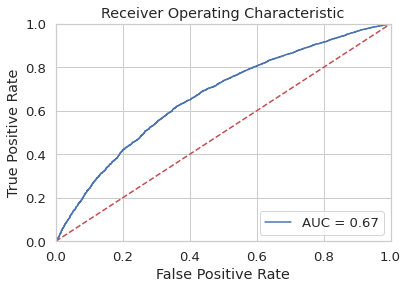

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Random Forest model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Random = RandomForestClassifier(n_estimators=5)

Random.fit(x_train, y_train)
print('Accuracy of randomforest classifier on training set: {:.2f}'
     .format((Random.score(x_train, y_train)*100)))
print('Accuracy of randomforest classifier on test set: {:.2f}'
     .format((Random.score(X_test, y_test)*100)))


Accuracy of randomforest classifier on training set: 97.71
Accuracy of randomforest classifier on test set: 75.03


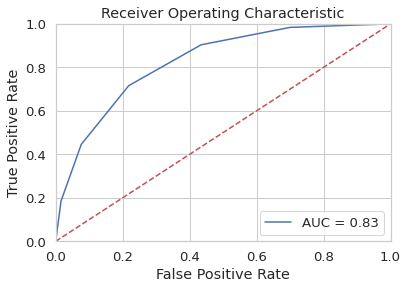

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = Random.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Decision Tree model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(x_train, y_train)
print('Accuracy of Adaboost classifier on training set: {:.2f}'
     .format((Adab.score(x_train, y_train)*100)))
print('Accuracy of Adaboost classifier on test set: {:.2f}'
     .format((Adab.score(X_test, y_test)*100)))


Accuracy of Adaboost classifier on training set: 77.25
Accuracy of Adaboost classifier on test set: 77.12


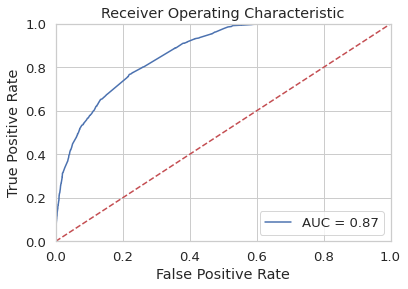

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = Adab.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**KNN model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
print('Accuracy of KNN on training set: {:.2f}'
     .format((classifier.score(x_train, y_train)*100)))
print('Accuracy of KNN on test set: {:.2f}'
     .format((classifier.score(X_test, y_test)*100)))


Accuracy of KNN on training set: 72.45
Accuracy of KNN on test set: 59.00


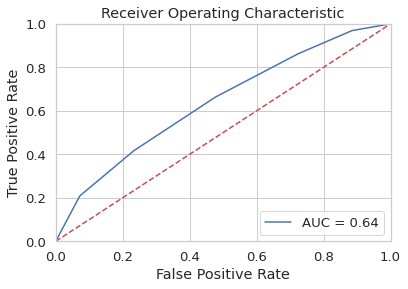

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**SVM model**

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(x_train, y_train)
print('Accuracy of SVM on training set: {:.2f}'
     .format((clf.score(x_train, y_train)*100)))
print('Accuracy of SVM on test set: {:.2f}'
     .format((clf.score(X_test, y_test)*100)))

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()